# End-to-end Dog breeds image classification

## Packages

In [1]:
# TODO: Import any packages that you might need
import sagemaker
role = sagemaker.get_execution_role()
sagemaker_session = sagemaker.Session()
bucket = 'udacity-mark'
prefix = 'Proj3'

## Dataset
TODO: Explain what dataset you are using for this project. Maybe even give a small overview of the classes, class distributions etc that can help anyone not familiar with the dataset get a better understand of it.

In [2]:
#TODO: Fetch and upload the data to AWS S3
# Manully upload into s3://udacity-mark/Proj3/dogImages
# /train
# /test
# /valid

## Hyperparameter Tuning
**TODO:** This is the part where you will finetune a pretrained model with hyperparameter tuning. Remember that you have to tune a minimum of two hyperparameters. However you are encouraged to tune more. You are also encouraged to explain why you chose to tune those particular hyperparameters and the ranges.

**Note:** You will need to use the `hpo.py` script to perform hyperparameter tuning.

In [3]:
from sagemaker.tuner import (
    IntegerParameter,
    CategoricalParameter,
    ContinuousParameter,
    HyperparameterTuner,
)

In [4]:
#TODO: Declare your HP ranges, metrics etc.
hyperparameter_ranges = {
    "lr": ContinuousParameter(0.001, 0.01),
    "batch-size": CategoricalParameter([32, 64]),
}

objective_metric_name = "average test loss"
objective_type = "Minimize"
metric_definitions = [{"Name": "average test loss", "Regex": "Test set: Average loss: ([0-9\\.]+)"}]

In [5]:
#TODO: Create estimators for your HPs
from sagemaker.pytorch import PyTorch

estimator = PyTorch(
    entry_point="hpo.py",
    role=role,
    py_version='py36',
    framework_version="1.8",
    instance_count=1,
    instance_type="ml.m5.xlarge",
    output_path='s3://{}/{}/model'.format(bucket, prefix)
)

tuner = HyperparameterTuner(
    estimator,
    objective_metric_name,
    hyperparameter_ranges,
    metric_definitions,
    max_jobs=4,
    max_parallel_jobs=4,
    objective_type=objective_type,
    base_tuning_job_name = 'ResNet18-finetune-SGD'
)

In [6]:
# TODO: Fit your estimator
inputs = 's3://udacity-mark/Proj3/dogImages/'
tuner.fit({"training": inputs}, wait=False)

No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config


In [12]:
#tuner.stop_tuning_job()

## Evaluation

### ResNet 18

In [4]:
import pandas as pd
tuning_job_name = 'ResNet18-finetune-SG-220912-2035'
ResNet18_tuner = sagemaker.HyperparameterTuningJobAnalytics(tuning_job_name)
ResNet18_df = tuner.dataframe()

In [5]:
ResNet18_df.sort_values('FinalObjectiveValue')

batch-size        lr                                TrainingJobName  \
2       "32"  0.008346  ResNet18-finetune-SG-220912-2035-002-d8597a67   
3       "32"  0.006664  ResNet18-finetune-SG-220912-2035-001-40054c95   
0       "64"  0.008794  ResNet18-finetune-SG-220912-2035-004-0f198088   
1       "64"  0.007956  ResNet18-finetune-SG-220912-2035-003-d08d09fa   

  TrainingJobStatus  FinalObjectiveValue         TrainingStartTime  \
2         Completed               0.4698 2022-09-12 20:36:54+00:00   
3         Completed               0.5105 2022-09-12 20:36:53+00:00   
0         Completed               0.6185 2022-09-12 20:37:03+00:00   
1         Completed               0.6499 2022-09-12 20:36:55+00:00   

            TrainingEndTime  TrainingElapsedTimeSeconds  
2 2022-09-13 03:56:38+00:00                     26384.0  
3 2022-09-13 04:06:40+00:00                     26987.0  
0 2022-09-13 04:15:10+00:00                     27487.0  
1 2022-09-13 04:15:48+00:00                     27533.0

### ResNet 50

In [8]:
tuning_job_name = 'pytorch-training-220913-1959'
ResNet50_tuner = sagemaker.HyperparameterTuningJobAnalytics(tuning_job_name)
ResNet50_df = ResNet50_tuner.dataframe()

In [9]:
ResNet50_df.sort_values('FinalObjectiveValue', ascending=0)

batch_size  learning_rate                            TrainingJobName  \
3      "128"       0.045615  pytorch-training-220913-1959-002-f0a42909   
0      "256"       0.015154  pytorch-training-220913-1959-005-273548a7   
2      "128"       0.006454  pytorch-training-220913-1959-003-63f4ccd1   
4      "128"       0.004339  pytorch-training-220913-1959-001-7448eecc   
1      "512"       0.007986  pytorch-training-220913-1959-004-07a9c393   

  TrainingJobStatus  FinalObjectiveValue         TrainingStartTime  \
3         Completed                579.0 2022-09-13 20:01:17+00:00   
0         Completed                337.0 2022-09-13 20:06:02+00:00   
2         Completed                100.0 2022-09-13 20:01:13+00:00   
4         Completed                 79.0 2022-09-13 20:01:14+00:00   
1            Failed                  NaN 2022-09-13 20:01:21+00:00   

            TrainingEndTime  TrainingElapsedTimeSeconds  
3 2022-09-14 05:29:31+00:00                     34094.0  
0 2022-09-14 05:35:39+00:00                     34177.0  
2 2022-09-14 05:26:27+00:00                     33914.0  
4 2022-09-14 05:26:59+00:00                     33945.0  
1 2022-09-13 20:05:04+00:00                       223.0

### See TuningJob results vs time

In [9]:
import bokeh
import bokeh.io

bokeh.io.output_notebook()
from bokeh.plotting import figure, show
from bokeh.models import HoverTool


class HoverHelper:
    def __init__(self, tuning_analytics):
        self.tuner = tuning_analytics

    def hovertool(self):
        tooltips = [
            ("FinalObjectiveValue", "@FinalObjectiveValue"),
            ("TrainingJobName", "@TrainingJobName"),
        ]
        for k in self.tuner.tuning_ranges.keys():
            tooltips.append((k, "@{%s}" % k))

        ht = HoverTool(tooltips=tooltips)
        return ht

    def tools(self, standard_tools="pan,crosshair,wheel_zoom,zoom_in,zoom_out,undo,reset"):
        return [self.hovertool(), standard_tools]


hover = HoverHelper(tuner)

p = figure(plot_width=900, plot_height=400, tools=hover.tools(), x_axis_type="datetime")
p.circle(source=full_df, x="TrainingStartTime", y="FinalObjectiveValue")
show(p)

Loading BokehJS ...

In [ ]:
# TODO: Get the best estimators and the best HPs

In [24]:
# ResNet 50
from sagemaker.tuner import HyperparameterTuner
RestNet_50_tuning_job_name = 'pytorch-training-220913-1959'
attached_tuner = HyperparameterTuner.attach(RestNet_50_tuning_job_name)

In [25]:
attached_tuner.best_estimator()


2022-09-14 05:27:01 Starting - Preparing the instances for training
2022-09-14 05:27:01 Downloading - Downloading input data
2022-09-14 05:27:01 Training - Training image download completed. Training in progress.
2022-09-14 05:27:01 Uploading - Uploading generated training model
2022-09-14 05:27:01 Completed - Resource released due to keep alive period expiry


In [26]:
attached_tuner.best_estimator().hyperparameters()


2022-09-14 05:27:01 Starting - Preparing the instances for training
2022-09-14 05:27:01 Downloading - Downloading input data
2022-09-14 05:27:01 Training - Training image download completed. Training in progress.
2022-09-14 05:27:01 Uploading - Uploading generated training model
2022-09-14 05:27:01 Completed - Resource released due to keep alive period expiry


{'_tuning_objective_metric': '"Test Loss"',
 'batch_size': '"128"',
 'learning_rate': '0.004338940031756185',
 'sagemaker_container_log_level': '20',
 'sagemaker_estimator_class_name': '"PyTorch"',
 'sagemaker_estimator_module': '"sagemaker.pytorch.estimator"',
 'sagemaker_job_name': '"Proj_4_pytorch_dog_hpo-2022-09-13-19-59-49-759"',
 'sagemaker_program': '"hpo.py"',
 'sagemaker_region': '"us-east-2"',
 'sagemaker_submit_directory': '"s3://sagemaker-us-east-2-800573291199/Proj_4_pytorch_dog_hpo-2022-09-13-19-59-49-759/source/sourcedir.tar.gz"'}

## Model Profiling and Debugging
TODO: Using the best hyperparameters, create and finetune a new model

**Note:** You will need to use the `train_model.py` script to perform model profiling and debugging.

In [ ]:
# TODO: Set up debugging and profiling rules and hooks

In [2]:
from sagemaker.pytorch import PyTorch
from sagemaker import get_execution_role
from sagemaker.debugger import (
    Rule,
    rule_configs,
    DebuggerHookConfig,
    ProfilerConfig,
    ProfilerRule,
    FrameworkProfile
)

In [3]:
rules = [
    Rule.sagemaker(rule_configs.vanishing_gradient()),
    Rule.sagemaker(rule_configs.overtraining()),
    Rule.sagemaker(rule_configs.loss_not_decreasing()),
    ProfilerRule.sagemaker(rule_configs.ProfilerReport()),
]

hook_config = DebuggerHookConfig(
    hook_parameters={"train.save_interval": "100", "eval.save_interval": "10"}
)

profiler_config = ProfilerConfig(
    system_monitor_interval_millis=500, framework_profile_params=FrameworkProfile(num_steps=10)
)

In [4]:
# TODO: Create and fit an estimator
hyperparameters = {
    "lr": 0.0083,
    "batch-size": 32
}

estimator = PyTorch(
    entry_point="train_model.py",
    base_job_name="ResNet18-finetune-SGD-final",
    role=get_execution_role(),
    instance_count=1,
    instance_type="ml.m4.xlarge",
    hyperparameters=hyperparameters,
    framework_version="1.8",
    py_version="py36",
    output_path='s3://{}/{}/model'.format(bucket, prefix),
    rules=rules,
    # Debugger parameters
    debugger_hook_config=hook_config,
    # Profiler parameters
    profiler_config=profiler_config,
)

In [7]:
inputs = 's3://udacity-mark/Proj3/dogImages/'
estimator.fit({"training": inputs}, wait=False)

### Analyze Debugger (ResNet18 as example

In [ ]:
# TODO: Plot a debugging output.

In [10]:
from sagemaker.estimator import Estimator
training_job_name = 'ResNet18-finetune-SGD-final-2022-09-13-18-42-58-650'
attached_estimator = Estimator.attach(training_job_name)


2022-09-14 06:43:33 Starting - Preparing the instances for training
2022-09-14 06:43:33 Downloading - Downloading input data
2022-09-14 06:43:33 Training - Training image download completed. Training in progress.
2022-09-14 06:43:33 Uploading - Uploading generated training model
2022-09-14 06:43:33 Completed - Training job completed


In [11]:
from smdebug.trials import create_trial
from smdebug.core.modes import ModeKeys
artifact_path = "s3://udacity-mark/Proj3/model/ResNet18-finetune-SGD-final-2022-09-13-18-42-58-650/debug-output/"
trial = create_trial(artifact_path)

[2022-09-15 15:26:08.532 ip-172-16-57-221.us-east-2.compute.internal:22902 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None
[2022-09-15 15:26:08.563 ip-172-16-57-221.us-east-2.compute.internal:22902 INFO s3_trial.py:42] Loading trial  at path s3://udacity-mark/Proj3/model/ResNet18-finetune-SGD-final-2022-09-13-18-42-58-650/debug-output/


In [12]:
# Print check what output tensors are saved
trial.tensor_names()

[2022-09-15 15:26:15.204 ip-172-16-57-221.us-east-2.compute.internal:22902 INFO trial.py:197] Training has ended, will refresh one final time in 1 sec.
[2022-09-15 15:26:16.223 ip-172-16-57-221.us-east-2.compute.internal:22902 INFO trial.py:210] Loaded all steps


['CrossEntropyLoss_output_0',
 'gradient/ResNet_bn1.bias',
 'gradient/ResNet_bn1.weight',
 'gradient/ResNet_conv1.weight',
 'gradient/ResNet_fc.bias',
 'gradient/ResNet_fc.weight',
 'gradient/ResNet_layer1.0.bn1.bias',
 'gradient/ResNet_layer1.0.bn1.weight',
 'gradient/ResNet_layer1.0.bn2.bias',
 'gradient/ResNet_layer1.0.bn2.weight',
 'gradient/ResNet_layer1.0.conv1.weight',
 'gradient/ResNet_layer1.0.conv2.weight',
 'gradient/ResNet_layer1.1.bn1.bias',
 'gradient/ResNet_layer1.1.bn1.weight',
 'gradient/ResNet_layer1.1.bn2.bias',
 'gradient/ResNet_layer1.1.bn2.weight',
 'gradient/ResNet_layer1.1.conv1.weight',
 'gradient/ResNet_layer1.1.conv2.weight',
 'gradient/ResNet_layer2.0.bn1.bias',
 'gradient/ResNet_layer2.0.bn1.weight',
 'gradient/ResNet_layer2.0.bn2.bias',
 'gradient/ResNet_layer2.0.bn2.weight',
 'gradient/ResNet_layer2.0.conv1.weight',
 'gradient/ResNet_layer2.0.conv2.weight',
 'gradient/ResNet_layer2.0.downsample.0.weight',
 'gradient/ResNet_layer2.0.downsample.1.bias',
 'g

In [13]:
len(trial.tensor("CrossEntropyLoss_output_0").steps(mode=ModeKeys.TRAIN))

15

In [14]:
len(trial.tensor("CrossEntropyLoss_output_0").steps(mode=ModeKeys.EVAL))

1

In [18]:
def get_data(trial, tname, mode):
    tensor = trial.tensor(tname)
    steps = tensor.steps(mode=mode)
    vals = []
    for s in steps:
        vals.append(tensor.value(s, mode=mode))
    return steps, vals

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import host_subplot


def plot_tensor(trial, tensor_name):

    steps_train, vals_train = get_data(trial, tensor_name, mode=ModeKeys.TRAIN)
    print("loaded TRAIN data")
    steps_eval, vals_eval = get_data(trial, tensor_name, mode=ModeKeys.EVAL)
    print("loaded EVAL data")

    fig = plt.figure(figsize=(10, 7))
    host = host_subplot(111)

    par = host.twiny()

    host.set_xlabel("Steps (TRAIN)")
    par.set_xlabel("Steps (EVAL)")
    host.set_ylabel(tensor_name)

    (p1,) = host.plot(steps_train, vals_train, label=tensor_name)
    print("completed TRAIN plot")
    (p2,) = par.plot(steps_eval, vals_eval, label="val_" + tensor_name)
    print("completed EVAL plot")
    leg = plt.legend()

    host.xaxis.get_label().set_color(p1.get_color())
    leg.texts[0].set_color(p1.get_color())

    par.xaxis.get_label().set_color(p2.get_color())
    leg.texts[1].set_color(p2.get_color())

    plt.ylabel(tensor_name)

    plt.show()

Matplotlib is building the font cache; this may take a moment.


loaded TRAIN data
loaded EVAL data
completed TRAIN plot
completed EVAL plot


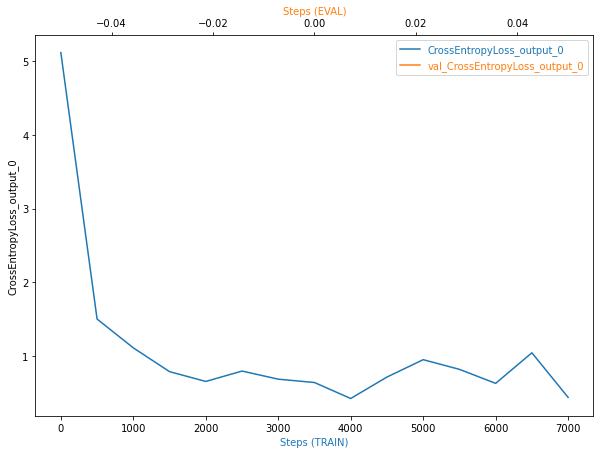

In [19]:
plot_tensor(trial, "CrossEntropyLoss_output_0")

### Analyze Profiler

In [ ]:
job_name = estimator.latest_training_job.name
client = estimator.sagemaker_session.sagemaker_client
description = client.describe_training_job(TrainingJobName=estimator.latest_training_job.name)

In [ ]:
from smdebug.trials import create_trial
from smdebug.core.modes import ModeKeys

trial = create_trial(estimator.latest_job_debugger_artifacts_path())

**TODO**: Is there some anomalous behaviour in your debugging output? If so, what is the error and how will you fix it?  
**TODO**: If not, suppose there was an error. What would that error look like and how would you have fixed it?

In [20]:
# TODO: Display the profiler output
rule_output_path = 's3://udacity-mark/Proj3/model/ResNet18-finetune-SGD-final-2022-09-13-18-42-58-650/rule-output/'

In [21]:
! aws s3 ls {rule_output_path} --recursive

2022-09-14 06:43:05     376338 Proj3/model/ResNet18-finetune-SGD-final-2022-09-13-18-42-58-650/rule-output/ProfilerReport/profiler-output/profiler-report.html
2022-09-14 06:43:05     224293 Proj3/model/ResNet18-finetune-SGD-final-2022-09-13-18-42-58-650/rule-output/ProfilerReport/profiler-output/profiler-report.ipynb
2022-09-14 06:43:00        193 Proj3/model/ResNet18-finetune-SGD-final-2022-09-13-18-42-58-650/rule-output/ProfilerReport/profiler-output/profiler-reports/BatchSize.json
2022-09-14 06:43:00        201 Proj3/model/ResNet18-finetune-SGD-final-2022-09-13-18-42-58-650/rule-output/ProfilerReport/profiler-output/profiler-reports/CPUBottleneck.json
2022-09-14 06:43:00       2457 Proj3/model/ResNet18-finetune-SGD-final-2022-09-13-18-42-58-650/rule-output/ProfilerReport/profiler-output/profiler-reports/Dataloader.json
2022-09-14 06:43:00        127 Proj3/model/ResNet18-finetune-SGD-final-2022-09-13-18-42-58-650/rule-output/ProfilerReport/profiler-output/profiler-reports/GPUMemoryIn

In [22]:
! aws s3 cp {rule_output_path} ./ --recursive

download: s3://udacity-mark/Proj3/model/ResNet18-finetune-SGD-final-2022-09-13-18-42-58-650/rule-output/ProfilerReport/profiler-output/profiler-report.ipynb to ProfilerReport/profiler-output/profiler-report.ipynb
download: s3://udacity-mark/Proj3/model/ResNet18-finetune-SGD-final-2022-09-13-18-42-58-650/rule-output/ProfilerReport/profiler-output/profiler-reports/BatchSize.json to ProfilerReport/profiler-output/profiler-reports/BatchSize.json
download: s3://udacity-mark/Proj3/model/ResNet18-finetune-SGD-final-2022-09-13-18-42-58-650/rule-output/ProfilerReport/profiler-output/profiler-reports/LoadBalancing.json to ProfilerReport/profiler-output/profiler-reports/LoadBalancing.json
download: s3://udacity-mark/Proj3/model/ResNet18-finetune-SGD-final-2022-09-13-18-42-58-650/rule-output/ProfilerReport/profiler-output/profiler-report.html to ProfilerReport/profiler-output/profiler-report.html
download: s3://udacity-mark/Proj3/model/ResNet18-finetune-SGD-final-2022-09-13-18-42-58-650/rule-outpu

In [21]:
import os

# get the autogenerated folder name of profiler report
profiler_report_name = [
    rule["RuleConfigurationName"]
    for rule in attached_estimator.latest_training_job.rule_job_summary()
    if "Profiler" in rule["RuleConfigurationName"]
][0]

In [22]:
import IPython

IPython.display.HTML(filename=profiler_report_name + "/profiler-output/profiler-report.html")

## Model Deploying

In [27]:
import sagemaker
role = sagemaker.get_execution_role()
sagemaker_session = sagemaker.Session()

In [28]:
from sagemaker.pytorch import PyTorchModel
from sagemaker.predictor import Predictor

jpeg_serializer = sagemaker.serializers.IdentitySerializer("image/jpeg")
json_deserializer = sagemaker.deserializers.JSONDeserializer()


class ImagePredictor(Predictor):
    def __init__(self, endpoint_name, sagemaker_session):
        super(ImagePredictor, self).__init__(
            endpoint_name,
            sagemaker_session=sagemaker_session,
            serializer=jpeg_serializer,
            deserializer=json_deserializer,
        )
        
model = PyTorchModel(
    entry_point="inference_final.py",
    source_dir="",
    role=role,
    model_data="s3://sagemaker-us-east-2-800573291199/pytorch-training-220913-1959-001-7448eecc/output/model.tar.gz",
    framework_version="1.3.1",
    py_version="py3",
    predictor_cls=ImagePredictor
)

In [30]:
predictor = model.deploy(initial_instance_count = 1,
                         instance_type = "ml.m5.xlarge",
                         endpoint_name = 'Dog-Breed-predictor'
                        )

-----!

## Example

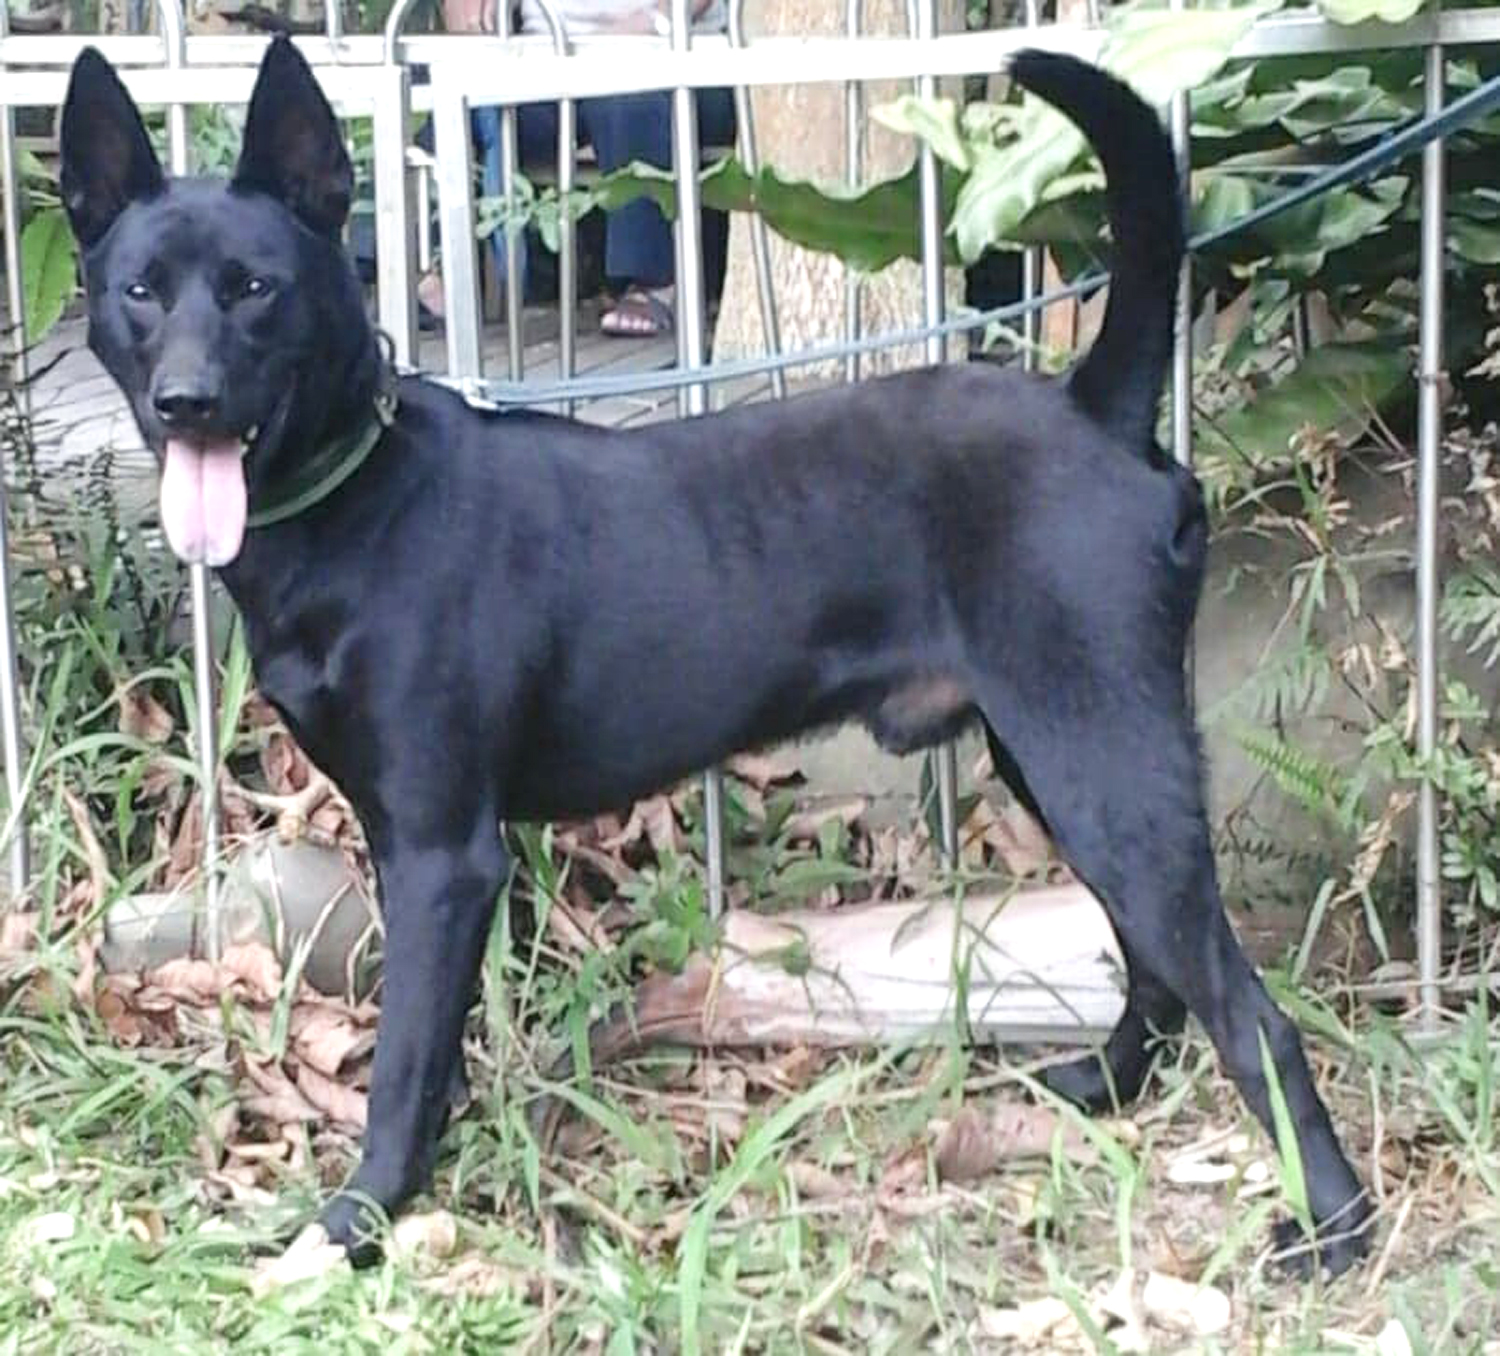

In [33]:
import requests
from PIL import Image
import io
import json

request_dict={ "url": "https://i.epochtimes.com/assets/uploads/2018/06/001-34159339_2063663717255211_7881560868457021440_n.jpg"}
img_bytes = requests.get(request_dict['url']).content
Image.open(io.BytesIO(img_bytes))

In [34]:
pred1 = predictor.predict(json.dumps(request_dict), initial_args={"ContentType": "application/json"})
pred1

'102.Manchester_terrier'

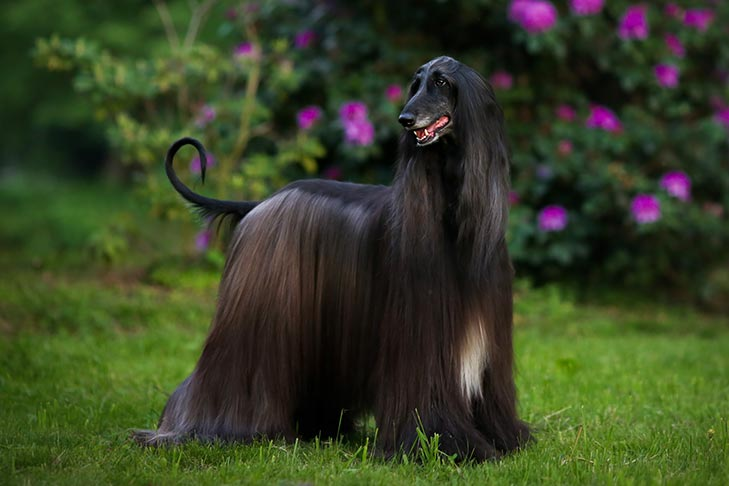

In [35]:
request_dict={ "url": "https://s3.amazonaws.com/cdn-origin-etr.akc.org/wp-content/uploads/2017/11/26151212/Afghan-Hound-standing-in-a-garden.jpg"}
img_bytes = requests.get(request_dict['url']).content
Image.open(io.BytesIO(img_bytes))

In [36]:
pred2 = predictor.predict(json.dumps(request_dict), initial_args={"ContentType": "application/json"})
pred2

'002.Afghan_hound'